<a href="https://colab.research.google.com/github/yenamalavinoothna/Customer-Churn-Prediction/blob/main/Customer_Churn_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
import scipy
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from collections import Counter
from imblearn.combine import SMOTEENN
plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Customer Churn/churn_file.csv")
df.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


In [ ]:
df.isnull().sum()

customerID          0
tenure              0
PhoneService        0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
df[df.duplicated()].shape[0]

0

In [ ]:
df.dtypes

customerID           object
tenure                int64
PhoneService         object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
df.drop('customerID',axis=1,inplace=True)

In [ ]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

In [ ]:
df.head(5)

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,34,Yes,One year,No,Mailed check,56.95,1889.50,No
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


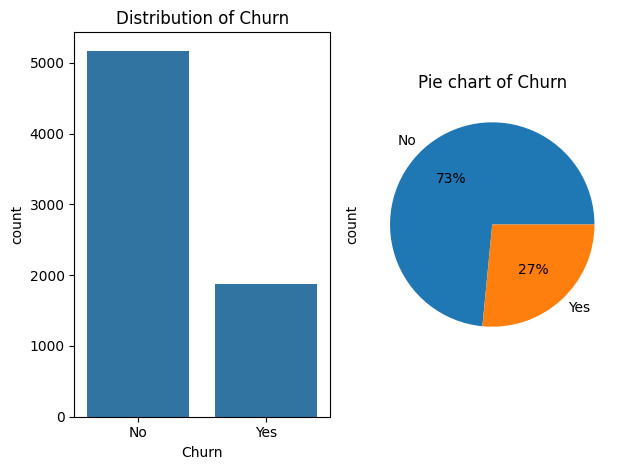

In [ ]:
plt.subplot(121)
sns.countplot(data=df,x="Churn")
plt.title("Distribution of Churn")
plt.subplot(122)
df['Churn'].value_counts().plot(kind='pie',autopct="%1.f%%",labels=['No','Yes'])
plt.title('Pie chart of Churn')
plt.tight_layout()
plt.show()

Since our dataset is highly imbalance we need to balance before fitting it into model

In [ ]:
#how much loss we are having because of customer churn
churn_customers=df[df["Churn"]=="Yes"]
loss=churn_customers["TotalCharges"].sum()
total_revenue=df["TotalCharges"].sum()
print("We have lost arround {}$ due to customer churn".format(loss))
print("We have lost arround {} percentage of revengue due to customer churn".format(np.round(loss/total_revenue*100,decimals=2)))

We have lost arround 2862926.9$ due to customer churn
We have lost arround 17.83 percentage of revengue due to customer churn


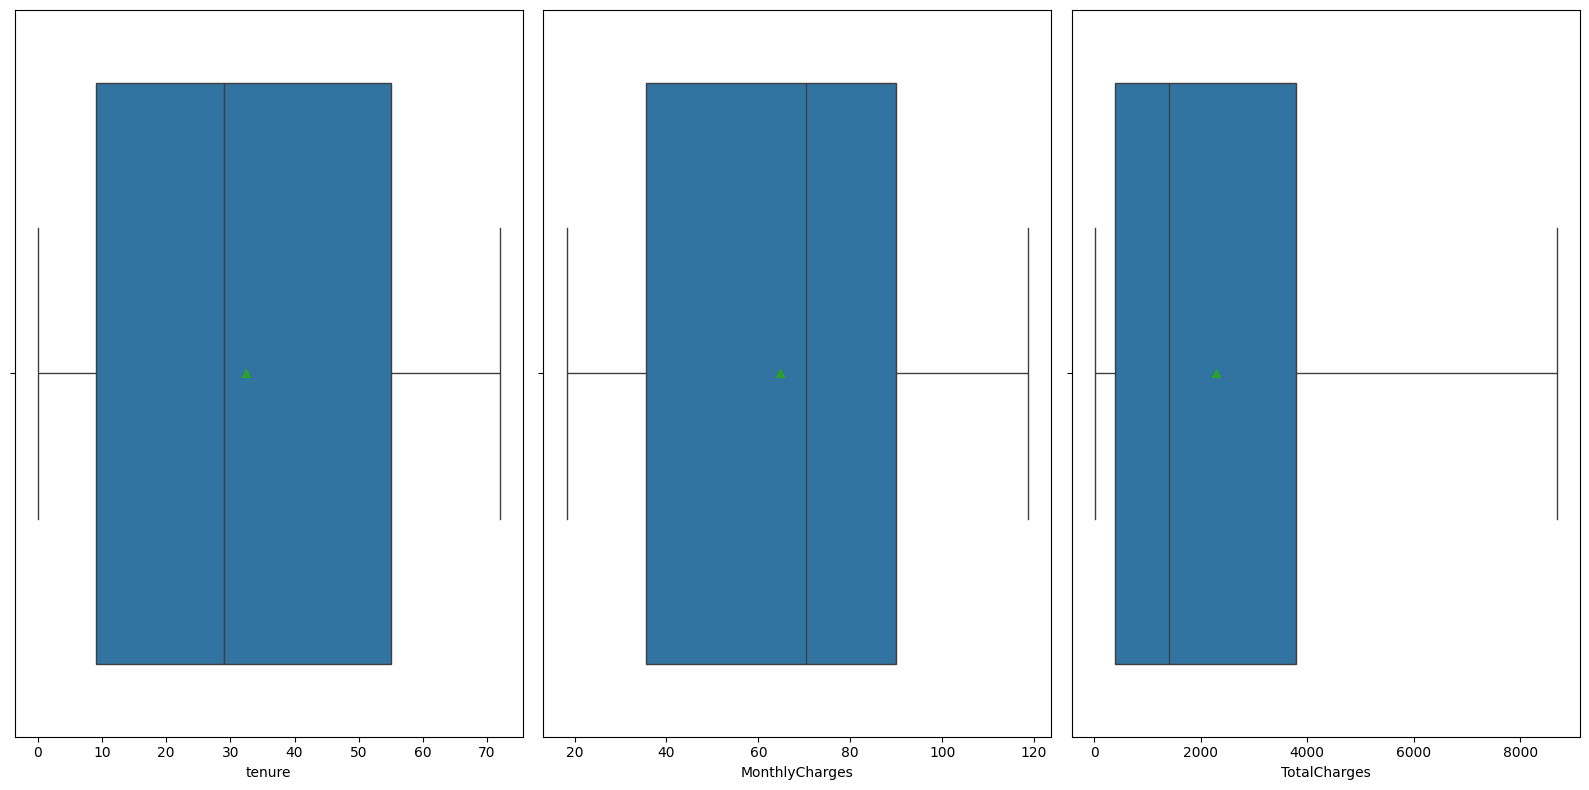

In [ ]:
#plot numerical features with boxplot
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(16,8))
axes=axs.flatten()
num_columns=['tenure', 'MonthlyCharges', 'TotalCharges']
for i,col in enumerate(num_columns):
    sns.boxplot(x=col,data=df,showmeans=True,ax=axes[i])
fig.tight_layout()
plt.show()

after plotting histogram and boxplot we found that there is no outlier present in numeric dataset so we don't need to do any kind of outlier treatment.

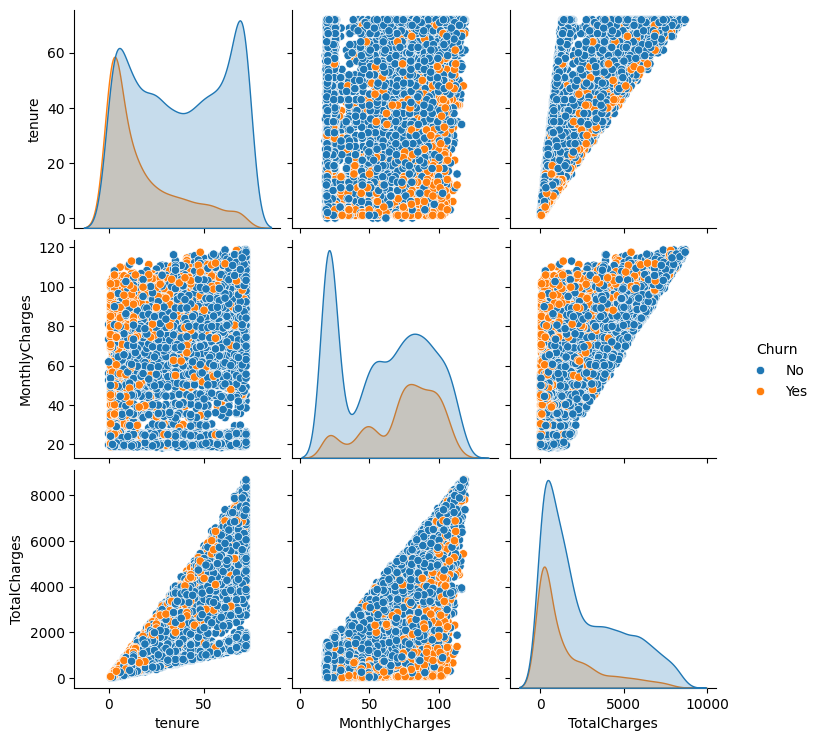

In [ ]:
sns.pairplot(df,hue="Churn",kind="scatter")
plt.show()

Univariate Analysis

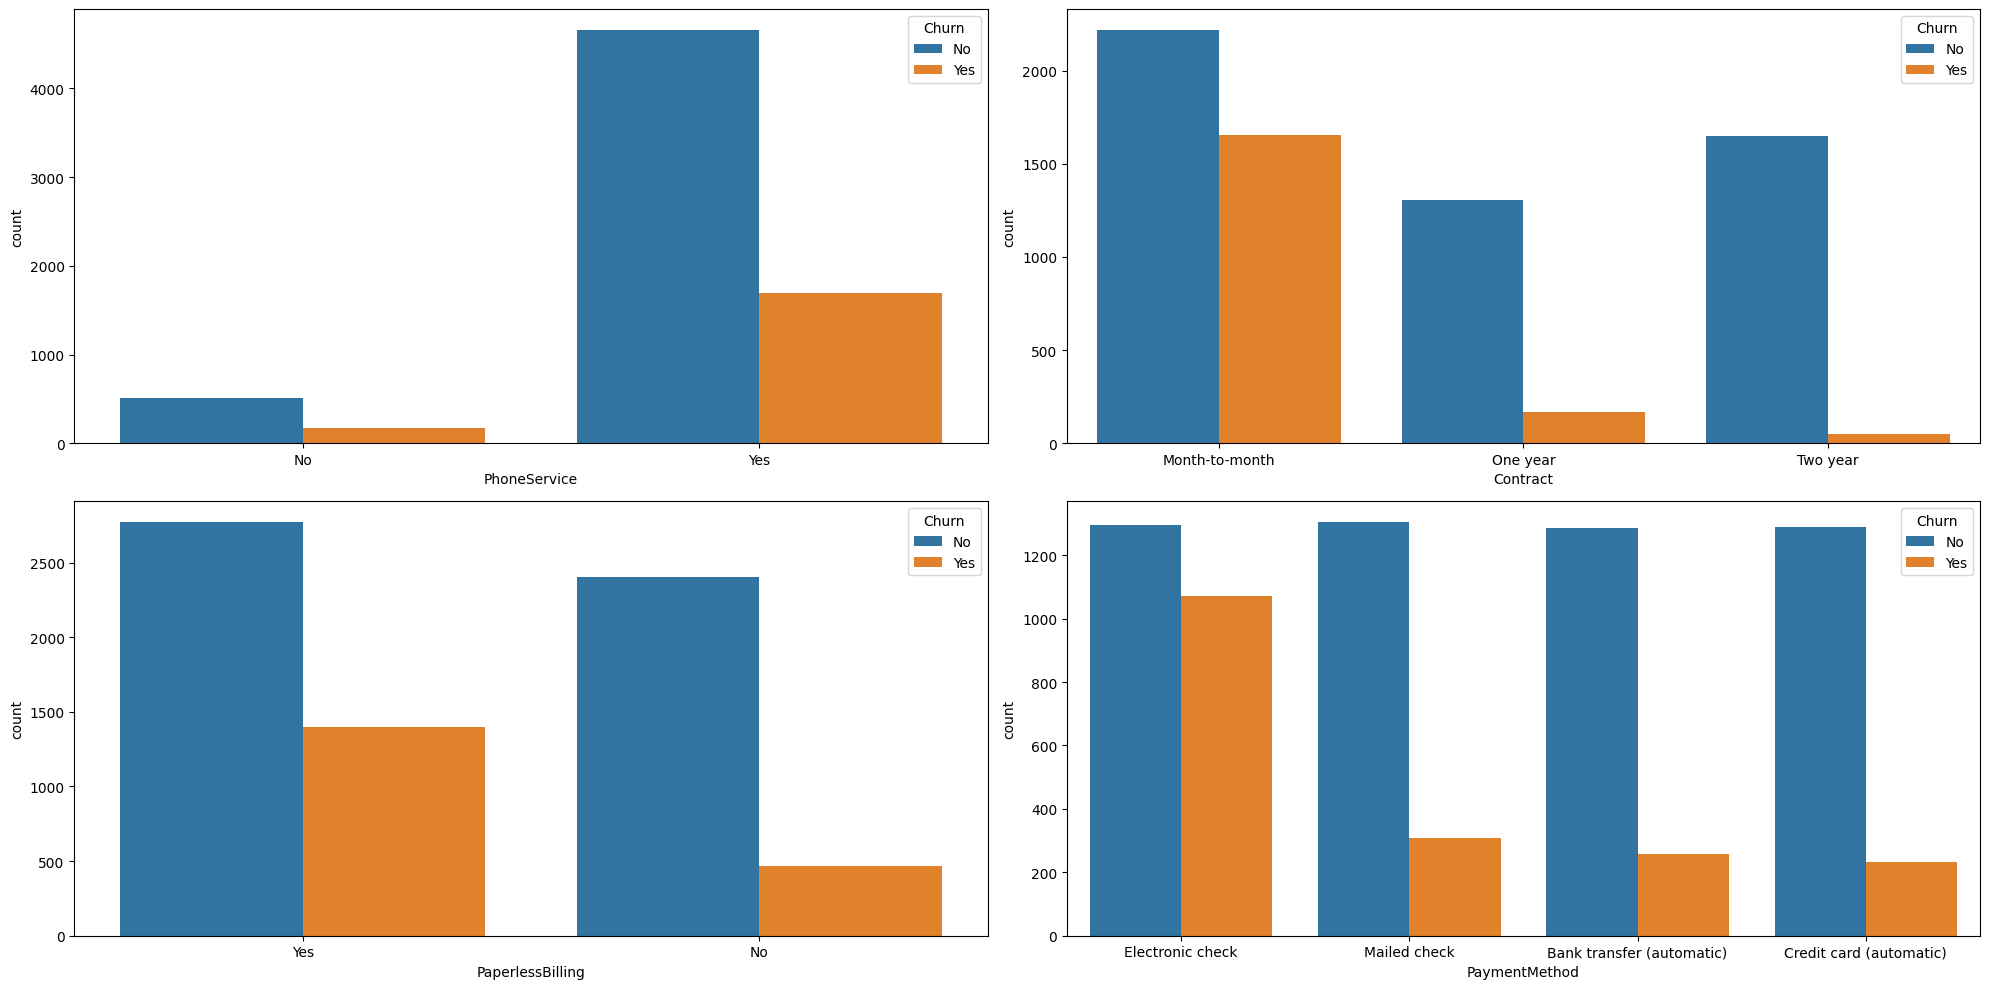

In [ ]:
cat_features=list(df.select_dtypes(include='object').columns)
cat_features.remove('Churn')


fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(20,10))
axes=axs.flatten()
for i,col in enumerate(cat_features):
    sns.countplot(x=col,hue="Churn",data=df,ax=axes[i])
#adjust spacing between subplots
fig.tight_layout()
plt.show()

In [ ]:
df.isnull().sum()

tenure               0
PhoneService         0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
df["TotalCharges"].fillna(df["TotalCharges"].mean(),inplace=True)

In [ ]:
df.isnull().sum()

tenure              0
PhoneService        0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
#encoding categorical values into numeric using label encoder
encoder=LabelEncoder()
df["PhoneService"] = encoder.fit_transform(df["PhoneService"])
df["Contract"] = encoder.fit_transform(df["Contract"])
df["PaperlessBilling"] = encoder.fit_transform(df["PaperlessBilling"])
df["PaymentMethod"] = encoder.fit_transform(df["PaymentMethod"])
df["Churn"] = encoder.fit_transform(df["Churn"])


In [ ]:
df.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,2,29.85,29.85,0
1,34,1,1,0,3,56.95,1889.50,0
2,2,1,0,1,3,53.85,108.15,1
3,45,0,1,0,0,42.30,1840.75,0
4,2,1,0,1,2,70.70,151.65,1


In [ ]:
df.dtypes

tenure                int64
PhoneService          int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

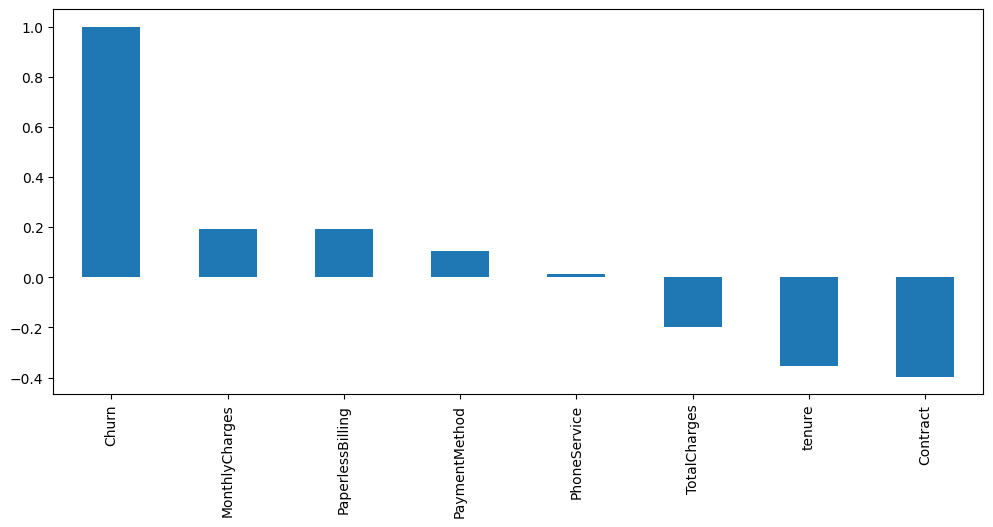

In [ ]:
#get correlation of churn with other variables
plt.figure(figsize=(12,5))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
plt.show()

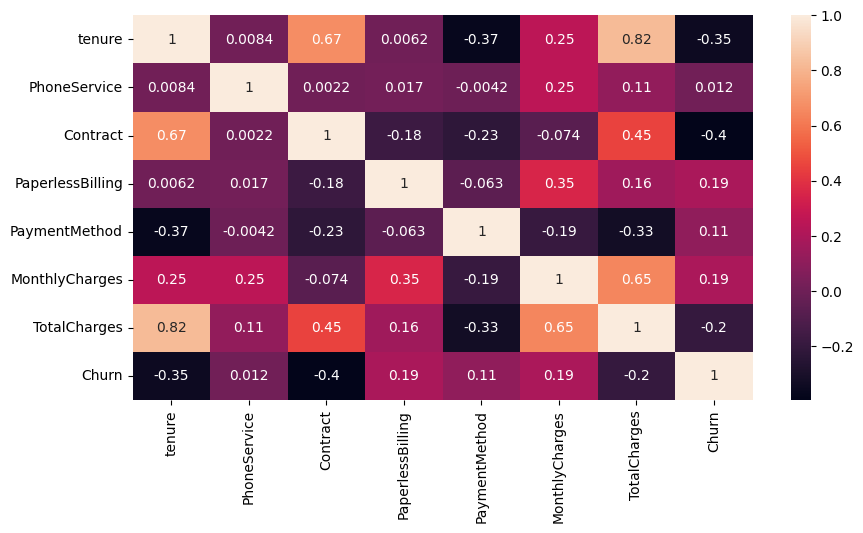

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [ ]:
#seperating independent variables and target variable
x=df.drop("Churn",axis=1)
y=df["Churn"]

In [ ]:
x.shape

(7043, 7)

Feature Selection
selecting only 5 features from available 7 features in the dataset which has higher correlation with churn



In [ ]:
select_feature=SelectKBest(k=5) #no of features to be selected
select_feature.fit(x,y)

SelectKBest(k=5)

In [ ]:
select_feature.get_feature_names_out()

array(['tenure', 'Contract', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [ ]:
x=x[select_feature.get_feature_names_out()]

In [ ]:
x.shape

(7043, 5)

according to the feature selection we have selected 5 top features out of 7 features

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((5634, 5), (5634,), (1409, 5), (1409,))

In [ ]:
def evaluate_model_performance(model,test_data):
    prediction=model.predict(test_data)
    print("Validation Accurary : {:.2f} %".format(accuracy_score(y_test,prediction)))
    print("Precision Score : {:.2f} %".format(precision_score(y_test,prediction)))
    print("Recall Score : {:.2f} %".format(recall_score(y_test,prediction)))
    print("F1 Score : {:.2f} %".format(f1_score(y_test,prediction)))
    #print(classification_report(y_test,prediction))

**Logistic** **Regression**

In [ ]:
model_2=LogisticRegression(random_state=0)
model_2.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [ ]:

evaluate_model_performance(model_2,x_test)

Validation Accurary : 0.80 %
Precision Score : 0.64 %
Recall Score : 0.58 %
F1 Score : 0.61 %


as we can see our model is not performing up to the mark because of imbalance nature of dataset so we will balance it to reduce True Negative(TN),False Negative(FN) and increase True Positive(TP),False Positive(FP).

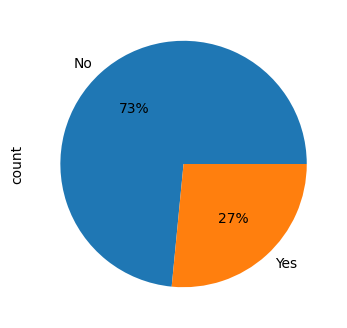

In [ ]:
plt.figure(figsize=(8,4))
y.value_counts().plot(kind="pie",autopct="%1.f%%",labels=['No','Yes'])
plt.show()

we have 2 classes class 0 and class 1. class 0 - majority class class 1 -minority class

In [ ]:
smote=SMOTEENN()
x_st,y_st=smote.fit_resample(x,y)

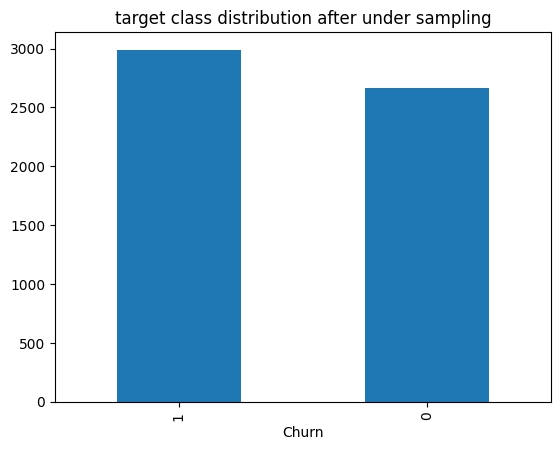

In [ ]:
y_st.value_counts().plot(kind="bar")
plt.title("target class distribution after under sampling")
plt.show()

In [ ]:
y_st.value_counts()

Churn
1    2989
0    2662
Name: count, dtype: int64

since we have performed SMOTEENN (combination of Smote + ENN) sampling method and we can see our dataset is nearly balanced

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(x_st,y_st,test_size=0.2,random_state=42)

In [ ]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((4520, 5), (4520,), (1131, 5), (1131,))

In [ ]:
model_LR=LogisticRegression(random_state=0)
model_LR.fit(X_train,Y_train)

LogisticRegression(random_state=0)

In [ ]:
prediction=model_LR.predict(X_test)
print("Validation Accurary : {:.2f} %".format(accuracy_score(Y_test,prediction)))
print("Precision Score : {:.2f} %".format(precision_score(Y_test,prediction)))
print("Recall Score : {:.2f} %".format(recall_score(Y_test,prediction)))
print("F1 Score : {:.2f} %".format(f1_score(Y_test,prediction)))

Validation Accurary : 0.91 %
Precision Score : 0.87 %
Recall Score : 0.95 %
F1 Score : 0.91 %


In [ ]:
y_pred_2=model_LR.predict(X_test)

In [ ]:
cm_2=confusion_matrix(Y_test,y_pred_2)
cm_2

array([[487,  81],
       [ 26, 537]])

In [ ]:
file=open("trained_model.pkl","wb")
pickle.dump(model_2,file)
file.close()

**Decision tree classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_3=DecisionTreeClassifier(random_state=0)
model_3.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

[Text(0.6187592137053513, 0.9852941176470589, 'x[1] <= 0.5\ngini = 0.39\nsamples = 5634\nvalue = [4138, 1496]'),
 Text(0.3354279414738215, 0.9558823529411765, 'x[3] <= 68.625\ngini = 0.489\nsamples = 3083\nvalue = [1768, 1315]'),
 Text(0.13547822032219728, 0.9264705882352942, 'x[0] <= 3.5\ngini = 0.419\nsamples = 1304\nvalue = [915, 389]'),
 Text(0.07501568070777763, 0.8970588235294118, 'x[3] <= 20.875\ngini = 0.497\nsamples = 456\nvalue = [246, 210]'),
 Text(0.043047669351643995, 0.8676470588235294, 'x[4] <= 20.575\ngini = 0.418\nsamples = 158\nvalue = [111, 47]'),
 Text(0.026937805361151458, 0.8382352941176471, 'x[3] <= 19.875\ngini = 0.472\nsamples = 102\nvalue = [63, 39]'),
 Text(0.011356133632642281, 0.8088235294117647, 'x[3] <= 19.775\ngini = 0.403\nsamples = 50\nvalue = [36, 14]'),
 Text(0.010299749108675559, 0.7794117647058824, 'x[3] <= 19.225\ngini = 0.413\nsamples = 48\nvalue = [34, 14]'),
 Text(0.0021127690479334476, 0.75, 'x[2] <= 0.5\ngini = 0.298\nsamples = 11\nvalue = [9

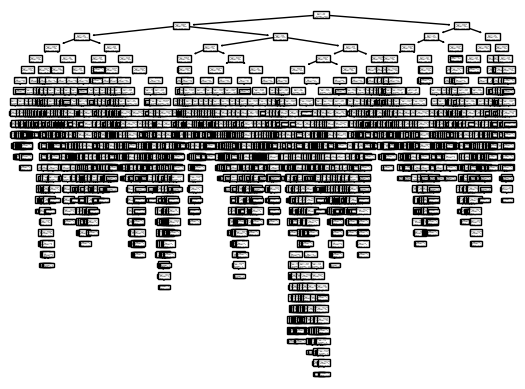

In [ ]:
from sklearn import tree
tree.plot_tree(model_3)

In [ ]:
y_pred_3=model_3.predict(x_test)
y_pred_3

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
evaluate_model_performance(model_3,x_test)

Validation Accurary : 0.72 %
Precision Score : 0.46 %
Recall Score : 0.48 %
F1 Score : 0.47 %


In [ ]:
cm_3=confusion_matrix(y_test,y_pred_3)
cm_3

array([[831, 205],
       [195, 178]])

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_4=RandomForestClassifier(n_estimators=15)
model_4.fit(x_train,y_train)

RandomForestClassifier(n_estimators=15)

In [ ]:
y_pred_4=model_4.predict(x_test)
y_pred_4

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
evaluate_model_performance(model_4,x_test)

Validation Accurary : 0.76 %
Precision Score : 0.55 %
Recall Score : 0.48 %
F1 Score : 0.52 %


In [ ]:
cm_4=confusion_matrix(y_test,y_pred_4)
cm_4

array([[891, 145],
       [193, 180]])

**K-Nearest Neighbour Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_5=KNeighborsClassifier(n_neighbors=5)
model_5.fit(x_train,y_train)

KNeighborsClassifier()

In [ ]:
y_pred_5=model_5.predict(x_test)
y_pred_5

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
evaluate_model_performance(model_5,x_test)

Validation Accurary : 0.78 %
Precision Score : 0.61 %
Recall Score : 0.49 %
F1 Score : 0.55 %


In [ ]:
cm_5=confusion_matrix(y_test,y_pred_5)
cm_5

array([[921, 115],
       [190, 183]])

**SGD Classifier**

In [ ]:
from sklearn.linear_model import SGDClassifier
model_6=SGDClassifier(max_iter=10)
model_6.fit(x_train,y_train)

SGDClassifier(max_iter=10)

In [ ]:
y_pred_6=model_6.predict(x_test)
y_pred_6

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
evaluate_model_performance(model_6,x_test)

Validation Accurary : 0.76 %
Precision Score : 0.57 %
Recall Score : 0.38 %
F1 Score : 0.46 %


In [ ]:
cm_6=confusion_matrix(y_test,y_pred_6)
cm_6

array([[930, 106],
       [230, 143]])

**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
model_7=SVC(degree=3)
model_7.fit(x_train,y_train)

SVC()

In [ ]:
y_pred_7=model_7.predict(x_test)
y_pred_7

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
evaluate_model_performance(model_7,x_test)

Validation Accurary : 0.74 %
Precision Score : 0.00 %
Recall Score : 0.00 %
F1 Score : 0.00 %


In [ ]:
cm_7=confusion_matrix(y_test,y_pred_7)
cm_7

array([[1036,    0],
       [ 373,    0]])

**Ada Boost Classification**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model_8=AdaBoostClassifier(n_estimators=100)
model_8.fit(x_train,y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
y_pred_8=model_8.predict(x_test)
y_pred_8

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
evaluate_model_performance(model_8,x_test)

Validation Accurary : 0.80 %
Precision Score : 0.66 %
Recall Score : 0.51 %
F1 Score : 0.57 %


In [ ]:
cm_8=confusion_matrix(y_test,y_pred_8)
cm_8

array([[938,  98],
       [183, 190]])